# Introduction 

## Motivation

In this tutorial, the topic of feature selection is explained on a chemical dataset containing information about the melting point (MP) of several molecules. Based on the structure of the molecule, several hundred features have been extracted, however some of them do not contain any useful information on the MP of molecules. 

When dealing with machine learning algorithms such as linear regression or decision trees for regression problems, we are eager to only use features that are important to the target variable and leave out unimportant ones, as they introduce bias to the model performance. In order to find those features that are useful to the target variable, we use several feature selection algorithms provided by the `sklearn` library. Then we train a multi-linear regression model and a decision tree on both, on all features and the selected ones in order to see whether and how much the model performance has increased. [1]

## Feature selection

Feature selection in ML is a crucial step in improving the model performance in both regression and classification, especially if there is a very high dimensional dataset in terms of predictors. When dealing with FL, mainly two different categories of algorithms are distinguished:

* Filters
* Wrappers

Filter algorithms, such as the *Mutual Information (MI)* filter in this tutorial, perform a ranking of features according to their information to the target variable. The features are ranked by a metric. In the case of *MI*, the features are ranked according to their mutual information they share with the target, which ranges between 0 and 1 (higher values are better). Filter algorithms do not use a ML model in the selection process and are therefore quite inexpensive to apply. However, they often perform worse than other FL approaches and they do not consider feature interactions in the selection process. [1,2] 

Besides filters, another approach of selecting an informative feature subset are wrapper algorithms. On the contrary to filters, wrappers use a learning algorithm to evaluate if a feature is useful or not. Furthermore, wrappers are generally known for performing better in feature selection than filters, because during the selection process, a model is repeatedly trained and tested in order to find the optimal feature subset. Another advantage of wrappers over filters is that dependencies and interactions between features are considered, so that there is no redundancy within the feature subset. A major disadvantage of wrappers is that the computational intensiveness grows with the number
of features to evaluate. In this tutorial, a wrapper approach called recursive feature elimination (RFE) in combination with a Random Forest (RF) model is used to determine the number of important features. RFE ranks features
after each training iteration. The algorithm starts with all features and after each training iteration, features with a low rank and therefore also a low discriminatory ability are removed from the dataset, as they do not contribute to the model performance. [1,2,3,4]

## Regression models

### Linear regression

Linear regression is used for linear problems involving the prediction of a quantitative variable. It is defined by the equation,

$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p$$

whereas $Y$ stands for the quantitative target and $X_1,...,X_p$ are the predictors describing $Y$. The regression coefficients $\beta_0,...,\beta_p$ are estimated during training using the so called least squares approach, where the regression coefficients are optimized in order to result in the lowest error. [1]


### Decision Trees

DTs are one of the most simple but most effective machine learning models available that
can be used either for regression or classification problems. According to the principle
of a DT, the population of samples is split into a minimum of two homogeneous subpopulations
based on the most important predictor variable $X_j$ of the entire feature
space $X$. Consequently, the sub-populations are further split based on other predictor
variables till all samples of the entire population are classified correctly. The DT gets its
name because of its shape which is the one of a tree. The root node represents the
entire population of samples, before any splitting into sub nodes is executed. In case a
sub node is split into further sub nodes, then it is called a decision node or internal node
whereas a sub node that does not split any further is called terminal node or simply leaf.
Concerning the building of a DT, the predictor space $X = (X_1,X_2,X_p)$ is divided
into J distinct and not overlapping regions which are referred as terminal
nodes. In order to make predictions, the class of the terminal node is simply the mode of
observations falling into that node. The DT follows a top-down greedy approach called
recursive binary splitting in order to grow a tree and reach the terminal nodes by splitting
the predictor space into two or more new branches (decision nodes). This approach is
described greedy because the algorithm will always select the predictor which will lead
to the best possible split, however it only cares about the current split and it does not
account for future splits that might lead to better model results. [1]

### Performance metric

The performance metric to compare the regression models is called root-mean-square error or RMSE. It is calculated like following:

$$RMSE = \sqrt{\frac{\sum_{i=1}^{n} (\hat{y}_i - y_i)^2}{n}}$$


# Code

## Import modules 

In [3]:
# Standard
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Base Estimator
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import OneHotEncoder

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Feature slection
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE


# Performance estimator 
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Set plotstyle for fancier plots
plt.style.use('seaborn')

## Data import

In order to import the data, we use pandas `read_csv` function. To get a sneak peak of the dataframe, we just call the `head()` method. 

In [5]:
df=pd.read_csv('data/mp_data_desc_alt.csv')
df.head(n=2)

,V1,compound,CSID,MP_Kelvin,SMILES,rdk_smiles,BalabanJ,BertzCT,Chi0,Chi0n,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,0,(-)-levonorgestrel,12560,509.15,O=C4\C=C3/[C@@H]([C@H]2CC[C@]1([C@@H](CC[C@]1(...,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,1.671196,597.453052,16.242276,14.183525,...,0xfr_sulfonamd,0xfr_sulfone,1xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.746050
1,1,"(1E,4E)-1,5-Di(2-naphthyl)-1,4-pentadien-3-one",4523376,516.65,O=C(\C=C\c2ccc1c(cccc1)c2)\C=C\c2ccc1c(cccc1)c2,O=C(/C=C/c1ccc2ccccc2c1)/C=C/c1ccc2ccccc2c1,1.489886,1057.599472,17.769374,14.300553,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.400873


As there are some columns that we do not need for further research, we use the `drop()` method in order to get rid of them. Remebmer to set `axis=1` to drop actual columns, as the default `axis=0` drops rows. 

In [6]:
dataset_clean = df.drop(['V1', 'compound', 'CSID', 'SMILES', 'rdk_smiles'], axis=1)
dataset_clean.head()

,MP_Kelvin,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,509.15,1.671196,597.453052,16.242276,14.183525,14.183525,11.043772,9.478974,9.478974,8.395266,...,0xfr_sulfonamd,0xfr_sulfone,1xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.746050
1,516.65,1.489886,1057.599472,17.769374,14.300553,14.300553,12.775990,8.656260,8.656260,6.282212,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.400873
2,360.90,2.181267,541.858095,12.087576,9.206315,9.206315,8.270857,5.326448,5.326448,3.625417,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.641274
3,461.15,2.258880,691.777798,14.535169,10.392675,10.392675,9.575387,5.825887,5.825887,4.063838,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.399765
4,463.15,2.084842,580.396040,13.664926,10.537213,10.537213,9.185872,5.843521,5.843521,4.017618,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.672316


## Preprocessing
In this step we are going to split the dataset into target column (`MP_Kelvin`), columns with numerical features and columns containing categorical features. The reason why we are doing this is that we have to treat numerical features differently from categorical ones. For the former, we are going to apply a `MinMaxScaler` to scale them all in a range from 0 and 1 to make them comparable. Otherwise, a feature having a larger scale will bias the model as it will have a higher influence on the target due to its value range regardless of the information it is containing. For the latter features (categorical) we are going to apply the `get_dummies` function of `pandas` in order to make them applicable to any model. In the last step, the three datasets will be merged together again. 

### Splitting base dataset
First of all, we get the target column `MP_Kelvin` by simple subsetting.

In [7]:
target = dataset_clean[['MP_Kelvin']]

Next we are going to apply list comprehension to identify all categorical features starting with 'fr_' and then print them. Having a list of the categorical feature names allows us to subset the dataset once again, leaving us with a dataframe containing only categorical features

In [8]:
feat_categorical = [col for col in dataset_clean.columns if 'fr_' in col]
print(feat_categorical)

['fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos

In [9]:
categorical = dataset_clean[feat_categorical]
categorical.head()

,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0xfr_Al_COO,1xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,0xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,1xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea
1,0xfr_Al_COO,0xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,0xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea
2,0xfr_Al_COO,0xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,1xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea
3,0xfr_Al_COO,0xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,1xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea
4,0xfr_Al_COO,0xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,1xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea


Last but not least, we create a dataframe containing only numerical features using again a list comprehensions.

In [10]:
feat_numeric = [col for col in dataset_clean.columns if 'fr_' not in col and 'MP_Kelvin' not in col]

In [11]:
numerical = dataset_clean[feat_numeric]
numerical.head()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,...,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,qed
0,1.671196,597.453052,16.242276,14.183525,14.183525,11.043772,9.478974,9.478974,8.395266,8.395266,...,0.0,0,0,0,0,0,0,0.0,48.166667,0.746050
1,1.489886,1057.599472,17.769374,14.300553,14.300553,12.775990,8.656260,8.656260,6.282212,6.282212,...,0.0,0,0,0,0,0,0,0.0,54.666667,0.400873
2,2.181267,541.858095,12.087576,9.206315,9.206315,8.270857,5.326448,5.326448,3.625417,3.625417,...,0.0,0,0,0,0,0,0,0.0,41.666667,0.641274
3,2.258880,691.777798,14.535169,10.392675,10.392675,9.575387,5.825887,5.825887,4.063838,4.063838,...,0.0,0,0,0,0,0,0,0.0,57.333333,0.399765
4,2.084842,580.396040,13.664926,10.537213,10.537213,9.185872,5.843521,5.843521,4.017618,4.017618,...,0.0,0,0,0,0,0,0,0.0,46.833333,0.672316


As all the columns are numerical, we can calculate correlations between them and visualize them using a heat-map. 

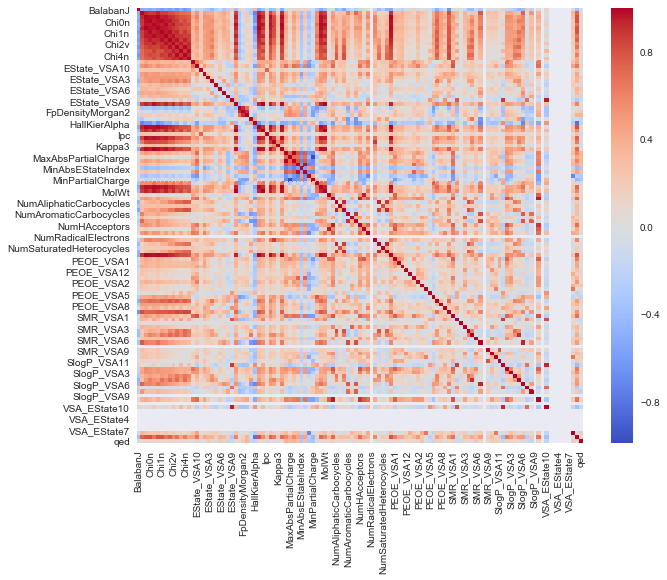

In [12]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(numerical.corr(), cmap = "coolwarm", ax=ax)

### Min-Max Scaling 

First of all we apply the `MinMaxScaler` to the dataframe `numerical`. We do that by first creating an object called `myScaler` and then doing `fit_transform` on our dataset. Min-Max scaling is often used to transform numerical predictors that have huge differences in scales. By transforming them into ranges between 0 and 1, we make them comparable among each other. For more information, see the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [13]:
myScaler = MinMaxScaler()

In [14]:
colnames = numerical.columns
numerical_scaled = pd.DataFrame(myScaler.fit_transform(numerical), index=None, columns=colnames)
numerical_scaled.head()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,...,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,qed
0,0.353975,0.262001,0.361420,0.402567,0.402567,0.377277,0.463002,0.463002,0.483764,0.483764,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.357444,0.763265
1,0.315571,0.463789,0.395400,0.405888,0.405888,0.436453,0.422817,0.422817,0.362003,0.362003,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.394624,0.335751
2,0.462012,0.237621,0.268970,0.261300,0.261300,0.282549,0.260171,0.260171,0.208909,0.208909,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.320263,0.633496
3,0.478451,0.303365,0.323433,0.294972,0.294972,0.327114,0.284566,0.284566,0.234172,0.234172,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.409878,0.334379
4,0.441589,0.254521,0.304069,0.299074,0.299074,0.313808,0.285428,0.285428,0.231509,0.231509,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.349817,0.671942


### Dummy-Encoding
In this step we are tranforming the categorical features into dummy variables. This approach has the advantage that even categorical features can be used for any ML model. However, having many categorical columns result in a very high-dimensional sparse matrix which might be very difficult to handle without any further feature selection strategy. For more information see the [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)

In [15]:
categorical_encoded = pd.get_dummies(categorical, prefix='')
categorical_encoded.head()

,_0xfr_Al_COO,_1xfr_Al_COO,_2xfr_Al_COO,_3xfr_Al_COO,_0xfr_Al_OH,_1xfr_Al_OH,_2xfr_Al_OH,_3xfr_Al_OH,_4xfr_Al_OH,_5xfr_Al_OH,...,_1xfr_unbrch_alkane,_2xfr_unbrch_alkane,_3xfr_unbrch_alkane,_4xfr_unbrch_alkane,_5xfr_unbrch_alkane,_6xfr_unbrch_alkane,_7xfr_unbrch_alkane,_9xfr_unbrch_alkane,_0xfr_urea,_1xfr_urea
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Creating final preprocessed dataset
In this step, the previously split dataset is combined together again using the `pd_concat` fucntions that takes a list of dataframes and concatenates them togehter. 

In [16]:
dataset_processed = pd.concat([target, numerical_scaled, categorical_encoded], axis = 1)
dataset_processed.head()

,MP_Kelvin,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,...,_1xfr_unbrch_alkane,_2xfr_unbrch_alkane,_3xfr_unbrch_alkane,_4xfr_unbrch_alkane,_5xfr_unbrch_alkane,_6xfr_unbrch_alkane,_7xfr_unbrch_alkane,_9xfr_unbrch_alkane,_0xfr_urea,_1xfr_urea
0,509.15,0.353975,0.262001,0.361420,0.402567,0.402567,0.377277,0.463002,0.463002,0.483764,...,0,0,0,0,0,0,0,0,1,0
1,516.65,0.315571,0.463789,0.395400,0.405888,0.405888,0.436453,0.422817,0.422817,0.362003,...,0,0,0,0,0,0,0,0,1,0
2,360.90,0.462012,0.237621,0.268970,0.261300,0.261300,0.282549,0.260171,0.260171,0.208909,...,0,0,0,0,0,0,0,0,1,0
3,461.15,0.478451,0.303365,0.323433,0.294972,0.294972,0.327114,0.284566,0.284566,0.234172,...,0,0,0,0,0,0,0,0,1,0
4,463.15,0.441589,0.254521,0.304069,0.299074,0.299074,0.313808,0.285428,0.285428,0.231509,...,0,0,0,0,0,0,0,0,1,0


### Create Train and test set

First of all we should create a train and a test set, as feature selection should only be used on the train set. Using the whole dataset (train and test) for feature selection might introduce some bias to regression models. [1] For more see the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [17]:
X = dataset_processed.drop('MP_Kelvin', axis = 1)
y = dataset_processed[['MP_Kelvin']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

In this step, we apply two different feature selection algorithms on the previously created train set. First of all, a univariate filter algorithm based on the **mutual information** between a feature and the target is applied. Then, we also apply a wrapper method called **Recursive Feature Elimination** based on a **Random Forest model**

### Mutual Information

MI determines the importance of a single feature by calculating the mutual information between predictor and target. It can be expressed by following equation:

$$MI = H(X) - H(Y|X)$$ 

whereas $H$ stands for the entropy and ranges from 0 to 1, whereas $H = 0$ means that there is no uncertainty in observing a variable  at all and $H = 1$ implies that there is no information and highest uncertainty. Applying this on the equation above means, that if a predictor $X$ is important to $Y$, $H(X)$ would be 1 and the conditional entropy $H(Y|X)$ would be zero. The resulting $MI$ would then have the maximum value of 1. [3]
For more information, see the [sklearn-documentation](http://sklearn.apachecn.org/cn/0.19.0/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression)

/Users/geraldcuder/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


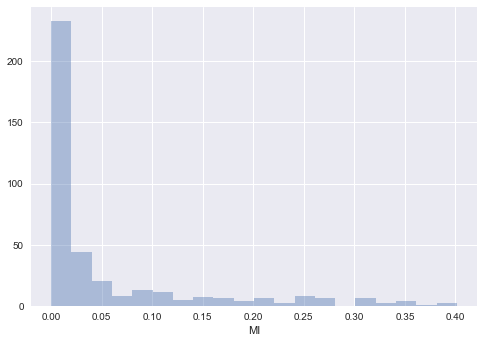

In [19]:
mreg = mutual_info_regression(X_train, y_train)
fs_results = pd.DataFrame(data = mreg, index = X_train.columns, columns=['MI'])
sns.distplot(fs_results['MI'], bins = 20, kde=False)

 It looks like there are a lot of unimportant features with a $MI$ lower than 0.1. So let's use only feature with a $MI \geq 1$

In [20]:
important_features_mi = fs_results[(fs_results.T >=0.1).any()].index
important_features_mi

Index(['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n',
       'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
       'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3',
       'EState_VSA4', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt',
       'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt',
       'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex',
       'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge',
       'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex',
       'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount',
       'NumAromaticCarbocycles', 'NumAromaticRings', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumValenceElectrons', 'PEOE_VSA1',
       'PEOE_VSA3', 'PEOE_VSA7', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1',
       'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA7', 'SlogP_VSA1',
       'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA

### Recursive Feature Elimination

As previously described, RFE performs feature selection using a model that has an inbuilt feature importance measure, such as RF. It starts with a full set of features, ranks them after training and removes a certain amount of badly ranked features. Then the model is trained again on the remaining feature set. This procedure is repeated till the desired number of features is reached. [4]

In [21]:
estimator = RandomForestRegressor()
selector = RFE(estimator, 60, step=1)
selector.fit(X_train, y_train)

/Users/geraldcuder/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  n_features_to_select=60, step=1, verbose=0)

In [22]:
important_features_rfe = X.T[selector.get_support()].index
important_features_rfe

Index(['BalabanJ', 'BertzCT', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n',
       'Chi3v', 'Chi4v', 'EState_VSA1', 'EState_VSA2', 'EState_VSA3',
       'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8',
       'EState_VSA9', 'FpDensityMorgan1', 'FpDensityMorgan2',
       'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomMolWt',
       'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex',
       'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge',
       'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex',
       'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'PEOE_VSA1',
       'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount',
       'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3',
       'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8', 'TPSA', 'VSA_EState10',
       'VSA_EState9', 'qed'],
      dtype='object')

## Regression models

For easier application, two functions have been defined that takes a list of models, train- and test set as well as a dictionary containing the feature sets as input. Then all the models are trained on all defined feature sets and the final RMSE on the test sets are stored in a dataframe

In [23]:
from collections import defaultdict
def compare_feature_selection(models, X_train, X_test, y_train, y_test, feat_sel):
    results_model = []
    names_model   = []
    
    for name, model in models:
        results_fs = defaultdict(list)
        for key in feat_sel:
            # Get features
            features = feat_sel[key]

            # fit model
            error = fit_regression_model(model, X_train[features], X_test[features], y_train, y_test)
            
            # Add results
            results_fs[key].append(error)
        
        results_model.append(pd.DataFrame(results_fs))
        names_model.append(name)
        
    df_final = pd.concat(results_model, axis=0).T
    df_final.columns = names_model
    return df_final

In [24]:
def fit_regression_model(model, X_train, X_test, y_train, y_test):
    from math import sqrt
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return sqrt(mean_squared_error(y_test, pred))

In [25]:
model_list = [("LR", LinearRegression()), ("DT", DecisionTreeRegressor(random_state=44)), ("RF", RandomForestRegressor())]
feat_dict = {
    "No Feature Selection":X.columns,
    "Mutual Information":important_features_mi, 
    "Random Forest-RFE": important_features_rfe
}

In [26]:
results = compare_feature_selection(model_list, X_train, X_test, y_train, y_test, feat_dict)

/Users/geraldcuder/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/geraldcuder/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/geraldcuder/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


# Results 

In [27]:
results

,LR,DT,RF
Mutual Information,6.263968e+01,69.145875,56.560574
No Feature Selection,6.588359e+13,64.885859,50.050308
Random Forest-RFE,6.018870e+01,69.820917,51.998893


## Discussion

Comparing the results among all feature selection methods and models, it can be seen that in the case of MLR, feature selection improves the model performance drastically. However, decision trees seem to perform worse. A reason for that might be, that single DTs are prone to overfitting on the training set. To overcome this issue, an ensembe of DTs is often used which is called Random Forest. Another reason for a worse model performance of DTs with pre-selected features might be that DTs are selecting their own features in the training process which are best for each individual split. Therefore a pre-selection might result in a selection bias and DTs perform worse. 

# Literature

[1]  Hastie, T., Tibshirani, R.,, Friedman, J. (2001). The Elements of Statistical Learning. New York, NY, USA: Springer New York Inc..  
[2] Chandrashekar, G., & Sahin, F. (2014). A survey on feature selection methods. Computers & Electrical Engineering, 40(1), 16–28.  
[3] A. Kraskov, H. Stogbauer and P. Grassberger, “Estimating mutual information”. Phys. Rev. E 69, 2004.  
[4] Guyon, I., Weston, J., Barnhill, S., & Vapnik, V., “Gene selection for cancer classification using support vector machines”, Mach. Learn., 46(1-3), 389–422, 2002.

# Further readings

As this tutorial does not cover the uprising topic of feature selection at all, here are some sources for further readings. 

#### More on ML and Statistics

If you want to read a good introduction on liner regression and decision trees, look at the reference book "An Introduction to Statisitical Learning" by Gareth James [(Source)](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) 


#### Boruta algorithm
If feature selection is performed, I personally recommend the `Boruta` algorithm which has proven to be very effective in many domains. It is based on Random Forest models and very easy to apply. Furthermore it is suitable for very high dimensional datasets with a lot of noise and can be used for either regression and classification problems. 

See the [paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=3&ved=2ahUKEwiE5snYosvaAhVGyaQKHT71DD4QFjACegQIABA-&url=https%3A%2F%2Fwww.jstatsoft.org%2Farticle%2Fview%2Fv036i11%2Fv36i11.pdf&usg=AOvVaw3tyiHN0BCe2fkkAA6xEVDE) and the implementation in python on [GitHub](https://github.com/scikit-learn-contrib/boruta_py)